# Paper results

In [1]:
import warnings
warnings.simplefilter('ignore')

import sys
from os.path import join
from functools import partial

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from amhelpers.config_parsing import load_config
from amhelpers.metrics import ece
from sklearn.metrics import confusion_matrix, roc_auc_score

from inpole.data import get_data_handler_from_config
from inpole.visualization import *
from inpole.pipeline import load_best_pipeline
from inpole.data.utils import get_feature_names
from inpole.data import RAData

In [2]:
# Default RC parameters for figures with size (6, 4).
RC_DEFAULT = {
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    'figure.titlesize': 18,
    'font.size': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.title_fontsize': 16,
    'legend.fontsize': 16,

}

# Default RC parameters for figures with size (4.5, 3).
RC_SMALL = {
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    'figure.titlesize': 13.5,
    'font.size': 13.5,
    'axes.titlesize': 13.5,
    'axes.labelsize': 13.5,
    'xtick.labelsize': 13.5,
    'ytick.labelsize': 13.5,
    'legend.title_fontsize': 12,
    'legend.fontsize': 12,
}

In [3]:
ESTIMATOR_MAPPER = {
    'riskslim': 'RS',
    'lr': 'LR',
    'dt': 'DT',
    'pronet': 'PN',
    'mlp': 'MLP',
    'prosenet': 'PSN',
    'rdt': 'RDT',
    'rnn': 'RNN',
}

In [4]:
SEQUENCE_MODELS = ['PSN', 'RDT', 'RNN']

In [5]:
STATES = [
    '$X_t$', '$A_{t-1}$', '$H_{(0)}$', r'$\bar{H}_t$', r'$H_{(0)}, \bar{H}_t$', 
    r'$H_{(1)}, \bar{H}_t$', r'$H_{(2)}, \bar{H}_t$', '$H_t$'
]
colors = sns.color_palette(n_colors=8)
COLOR_MAPPER = dict(zip(STATES, colors))

## Overall performance

In [6]:
adni_paths = [
    ('$X_t$',                 '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1352_sweep'),
    ('$A_{t-1}$',             '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1353_sweep'),
    ('$H_{(0)}$',             '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1354_sweep'),
    (r'$\bar{H}_t$',          '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1355_sweep'),  # max
    (r'$H_{(0)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1356_sweep'),  # max
    (r'$H_{(1)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1357_sweep'),  # max
    (r'$H_{(2)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1358_sweep'),  # max
    (r'$\bar{H}_t$',          '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1359_sweep'),  # sum
    (r'$H_{(0)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1400_sweep'),  # sum
    (r'$H_{(1)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1401_sweep'),  # sum
    (r'$H_{(2)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1402_sweep'),  # sum
    (r'$\bar{H}_t$',          '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1403_sweep'),  # mean
    (r'$H_{(0)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1404_sweep'),  # mean
    (r'$H_{(1)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1405_sweep'),  # mean
    (r'$H_{(2)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1406_sweep'),  # mean
    ('$H_t$',                 '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1407_sweep'),
]

In [7]:
ra_paths = [
    ('$X_t$',                 '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1931_sweep'),
    ('$A_{t-1}$',             '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1932_sweep'),
    ('$H_{(0)}$',             '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1933_sweep'),
    (r'$\bar{H}_t$',          '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1934_sweep'),  # max
    (r'$H_{(0)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1935_sweep'),  # max
    (r'$H_{(1)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1936_sweep'),  # max
    (r'$H_{(2)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1937_sweep'),  # max
    (r'$\bar{H}_t$',          '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1938_sweep'),  # sum
    (r'$H_{(0)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1939_sweep'),  # sum
    (r'$H_{(1)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1940_sweep'),  # sum
    (r'$H_{(2)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1941_sweep'),  # sum
    (r'$\bar{H}_t$',          '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1942_sweep'),  # mean
    (r'$H_{(0)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1943_sweep'),  # mean
    (r'$H_{(1)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1944_sweep'),  # mean
    (r'$H_{(2)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1945_sweep'),  # mean
    ('$H_t$',                 '/mimer/NOBACKUP/groups/inpole/results/ra/20240901_1946_sweep'),
]

In [8]:
sepsis_paths = [
    ('$X_t$',                 '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2120_sweep'),
    ('$A_{t-1}$',             '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2121_sweep'),
    ('$H_{(0)}$',             '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2122_sweep'),
    (r'$\bar{H}_t$',          '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2123_sweep'),  # max
    (r'$H_{(0)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2124_sweep'),  # max
    (r'$H_{(1)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2125_sweep'),  # max
    (r'$H_{(2)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2126_sweep'),  # max
    (r'$\bar{H}_t$',          '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2127_sweep'),  # sum
    (r'$H_{(0)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2128_sweep'),  # sum
    (r'$H_{(1)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2129_sweep'),  # sum
    (r'$H_{(2)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2130_sweep'),  # sum
    (r'$\bar{H}_t$',          '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2131_sweep'),  # mean
    (r'$H_{(0)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2132_sweep'),  # mean
    (r'$H_{(1)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2133_sweep'),  # mean
    (r'$H_{(2)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2134_sweep'),  # mean
    ('$H_t$',                 '/mimer/NOBACKUP/groups/inpole/results/sepsis/20240831_2135_sweep'),
]

In [9]:
copd_paths = [
    ('$X_t$',                 '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0934_sweep'),
    ('$A_{t-1}$',             '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0935_sweep'),
    ('$H_{(0)}$',             '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0936_sweep'),
    (r'$\bar{H}_t$',          '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0937_sweep'),  # max
    (r'$H_{(0)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0938_sweep'),  # max
    (r'$H_{(1)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0939_sweep'),  # max
    (r'$H_{(2)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0940_sweep'),  # max
    (r'$\bar{H}_t$',          '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0941_sweep'),  # sum
    (r'$H_{(0)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0942_sweep'),  # sum
    (r'$H_{(1)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0943_sweep'),  # sum
    (r'$H_{(2)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0944_sweep'),  # sum
    (r'$\bar{H}_t$',          '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0945_sweep'),  # mean
    (r'$H_{(0)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0946_sweep'),  # mean
    (r'$H_{(1)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0947_sweep'),  # mean
    (r'$H_{(2)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0948_sweep'),  # mean
    ('$H_t$',                 '/mimer/NOBACKUP/groups/inpole/results/copd/20240902_0949_sweep'),
]

In [10]:
all_experiment_paths = {
    'ADNI': adni_paths,
    'RA': ra_paths,
    'Sepsis': sepsis_paths,
    'COPD': copd_paths
}

all_scores = get_all_scores(all_experiment_paths)

In [11]:
all_scores['AUC'] = all_scores['auc'].combine_first(all_scores['auc_macro'])

In [12]:
scoring_kwargs = dict(
    exclude_models=['rdt_aligned', 'rdt_pruned', 'pronet'],
    experiment_order=all_experiment_paths,
    model_order=ESTIMATOR_MAPPER,
    index=dict(ra_paths),
)

In [13]:
table_auc = get_scoring_table(all_scores, metric='AUC', include_cis=False, **scoring_kwargs)

In [14]:
table_auc_cis = get_scoring_table(all_scores, metric='AUC', include_cis=True, **scoring_kwargs)

In [15]:
table_ece = get_scoring_table(all_scores, metric='ece', include_cis=False, **scoring_kwargs)

In [16]:
table_sce = get_scoring_table(all_scores, metric='sce', include_cis=False, **scoring_kwargs)

### AUC 

In [17]:
for reduction in ['sum', 'mean', 'max']:
    print(f'----- Reduction: {reduction} -----\n')
    table_auc_agg = table_auc[
        table_auc.index.get_level_values('reduction').isin(['none', reduction])
    ].droplevel(['reduction', 'state_dim'])

    table_auc_agg_1, table_auc_agg_2 = get_table_sections(table_auc_agg, SEQUENCE_MODELS)
    
    table_auc_agg_1.style.to_latex(buf=sys.stdout, position='t', hrules=True, siunitx=True)
    print()
    table_auc_agg_2.style.to_latex(buf=sys.stdout, position='t', hrules=True, siunitx=True)
    print()

----- Reduction: sum -----

\begin{table}[t]
\begin{tabular}{llllllllllllll}
\toprule
{} & \multicolumn{4}{r}{ADNI} & \multicolumn{3}{r}{RA} & \multicolumn{3}{r}{Sepsis} & \multicolumn{3}{r}{COPD} \\
{estimator} & {RS} & {LR} & {DT} & {MLP} & {LR} & {DT} & {MLP} & {LR} & {DT} & {MLP} & {LR} & {DT} & {MLP} \\
{state} & {} & {} & {} & {} & {} & {} & {} & {} & {} & {} & {} & {} & {} \\
\midrule
$X_t$ & 54.2 & 56.2 & 53.9 & 55.6 & 61.8 & 58.8 & 61.4 & 82.1 & 78.2 & 84.1 & 77.9 & 74.7 & 78.8 \\
$A_{t-1}$ & 52.0 & 53.9 & 53.8 & 53.7 & 94.7 & 94.7 & 94.7 & 88.0 & 90.6 & 91.1 & 92.9 & 95.0 & 95.0 \\
$H_{(0)}$ & 53.4 & 56.8 & 54.3 & 56.8 & 95.6 & 95.7 & 96.0 & 91.3 & 92.1 & 94.7 & 94.0 & 96.0 & 95.4 \\
$\bar{H}_t$ & 63.0 & 64.4 & 64.9 & 64.1 & 90.5 & 92.0 & 94.0 & 84.6 & 85.2 & 89.1 & 91.1 & 89.3 & 93.5 \\
$H_{(0)}, \bar{H}_t$ & 63.7 & 65.3 & 65.0 & 65.8 & 96.1 & 96.4 & 96.9 & 91.9 & 92.3 & 95.3 & 94.7 & 96.7 & 96.3 \\
$H_{(1)}, \bar{H}_t$ & 63.4 & 65.6 & 65.4 & 66.0 & 96.0 & 96.4 & 96.9 & 92.2

### AUC with confidence intervals

In [18]:
reduction = 'sum'

table_auc_cis_sum = table_auc_cis[
    table_auc.index.get_level_values('reduction').isin(['none', reduction])
].droplevel(['reduction', 'state_dim'])

table_auc_cis_sum.style.to_latex(buf=sys.stdout, position='t', hrules=True, siunitx=True)

\begin{table}[t]
\begin{tabular}{lllllllll}
\toprule
{} & {estimator} & {RS} & {LR} & {DT} & {MLP} & {PSN} & {RDT} & {RNN} \\
{data} & {state} & {} & {} & {} & {} & {} & {} & {} \\
\midrule
\multirow[c]{8}{*}{ADNI} & $X_t$ & \begin{tabular}[c]{@{}c@{}}54.2\\(51.4, 57.0)\end{tabular} & \begin{tabular}[c]{@{}c@{}}56.2\\(54.4, 57.4)\end{tabular} & \begin{tabular}[c]{@{}c@{}}53.9\\(52.1, 55.9)\end{tabular} & \begin{tabular}[c]{@{}c@{}}55.6\\(54.1, 57.0)\end{tabular} & - & - & - \\
 & $A_{t-1}$ & \begin{tabular}[c]{@{}c@{}}52.0\\(51.1, 53.0)\end{tabular} & \begin{tabular}[c]{@{}c@{}}53.9\\(52.3, 55.6)\end{tabular} & \begin{tabular}[c]{@{}c@{}}53.8\\(52.4, 55.4)\end{tabular} & \begin{tabular}[c]{@{}c@{}}53.7\\(52.5, 55.4)\end{tabular} & - & - & - \\
 & $H_{(0)}$ & \begin{tabular}[c]{@{}c@{}}53.4\\(51.1, 55.7)\end{tabular} & \begin{tabular}[c]{@{}c@{}}56.8\\(55.2, 58.1)\end{tabular} & \begin{tabular}[c]{@{}c@{}}54.3\\(52.7, 56.1)\end{tabular} & \begin{tabular}[c]{@{}c@{}}56.8\\(54.9, 58.8)\en

### Calibration error

In [19]:
reduction = 'sum'

In [20]:
# ADNI (ECE)

table_ece_sum = table_ece[
        table_ece.index.get_level_values('reduction').isin(['none', reduction])
    ].droplevel(['reduction', 'state_dim'])

table_ece_sum = table_ece_sum[table_ece_sum.index.get_level_values('data') == 'ADNI']

table_ece_sum_1, table_ece_sum_2 = get_table_sections(table_ece_sum, SEQUENCE_MODELS)

In [21]:
# RA, Sepsis, and COPD (SCE)

table_sce_sum = table_sce[
        table_sce.index.get_level_values('reduction').isin(['none', reduction])
    ].droplevel(['reduction', 'state_dim'])

table_sce_sum = table_sce_sum[table_sce_sum.index.get_level_values('data') != 'ADNI']

table_sce_sum_1, table_sce_sum_2 = get_table_sections(table_sce_sum, SEQUENCE_MODELS)

In [22]:
table_cal_sum_1 = pd.concat([table_ece_sum_1, table_sce_sum_1], axis=1)
table_cal_sum_2 = pd.concat([table_ece_sum_2, table_sce_sum_2], axis=1)

In [23]:
table_cal_sum_1.style.to_latex(buf=sys.stdout, position='t', hrules=True, siunitx=True)
print()
table_cal_sum_2.style.to_latex(buf=sys.stdout, position='t', hrules=True, siunitx=True)

\begin{table}[t]
\begin{tabular}{llllllllllllll}
\toprule
{} & \multicolumn{4}{r}{ADNI} & \multicolumn{3}{r}{RA} & \multicolumn{3}{r}{Sepsis} & \multicolumn{3}{r}{COPD} \\
{estimator} & {RS} & {LR} & {DT} & {MLP} & {LR} & {DT} & {MLP} & {LR} & {DT} & {MLP} & {LR} & {DT} & {MLP} \\
{state} & {} & {} & {} & {} & {} & {} & {} & {} & {} & {} & {} & {} & {} \\
\midrule
$X_t$ & 8.6 & 1.9 & 3.5 & 2.2 & 1.1 & 1.3 & 1.4 & 0.2 & 0.3 & 0.2 & 0.4 & 0.4 & 0.5 \\
$A_{t-1}$ & 8.8 & 1.5 & 2.0 & 2.4 & 0.4 & 0.4 & 0.7 & 1.0 & 0.1 & 0.2 & 0.9 & 0.2 & 0.3 \\
$H_{(0)}$ & 8.2 & 2.3 & 4.0 & 2.8 & 0.6 & 0.5 & 0.7 & 0.6 & 0.1 & 0.2 & 0.6 & 0.2 & 0.4 \\
$\bar{H}_t$ & 5.3 & 2.8 & 2.7 & 3.9 & 3.5 & 1.3 & 1.1 & 0.4 & 0.2 & 0.2 & 0.6 & 0.5 & 0.4 \\
$H_{(0)}, \bar{H}_t$ & 10.1 & 2.6 & 2.6 & 3.6 & 0.9 & 0.5 & 0.8 & 0.6 & 0.1 & 0.2 & 0.5 & 0.2 & 0.4 \\
$H_{(1)}, \bar{H}_t$ & 7.6 & 2.7 & 3.3 & 2.9 & 1.0 & 0.5 & 0.8 & 0.5 & 0.1 & 0.2 & 0.5 & 0.2 & 0.4 \\
$H_{(2)}, \bar{H}_t$ & 7.9 & 2.7 & 3.1 & 2.4 & 1.0 & 0.5 & 1.0 & 0

### Contextualized policy recovery (CPR)

In [24]:
cpr_paths = [
    '/mimer/NOBACKUP/groups/inpole/results/adni/cpr_results/0/context_RNN_32_0.0001.pkl',  # trial 01
    '/mimer/NOBACKUP/groups/inpole/results/adni/cpr_results/1/context_RNN_64_0.0001.pkl',  # trial 02
    '/mimer/NOBACKUP/groups/inpole/results/adni/cpr_results/2/context_RNN_16_0.0001.pkl',  # trial 03
    '/mimer/NOBACKUP/groups/inpole/results/adni/cpr_results/3/context_RNN_16_0.001.pkl',  # trial 04
    '/mimer/NOBACKUP/groups/inpole/results/adni/cpr_results/4/context_RNN_64_0.0001.pkl',  # trial 05
]

cpr_aucs, cpr_eces = [], []

for cpr_path in cpr_paths:
    cpr = joblib.load(cpr_path)
    cpr_aucs.append(roc_auc_score(cpr['true'], cpr['preds']))
    cpr_eces.append(ece(cpr['true'].flatten(), cpr['preds']))

print(f'AUC: {100 * np.mean(cpr_aucs):0.2f}')
print(f'ECE: {100 * np.mean(cpr_eces):0.2f}')

AUC: 68.62
ECE: 2.14


## Sepsis analysis

In [25]:
sepsis_results = joblib.load('/mimer/NOBACKUP/groups/inpole/results/results_sepsis.pickle')

### Performance w.r.t. patient groups

In [26]:
sepsis_groups = pd.DataFrame(sepsis_results['groups'][1:], columns=sepsis_results['groups'][0])
sepsis_groups.Estimator.replace(ESTIMATOR_MAPPER, inplace=True)

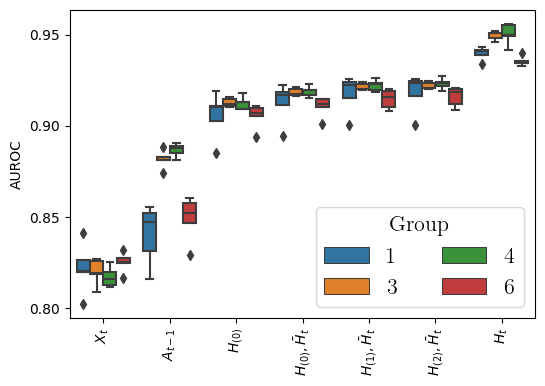

In [27]:
mask = (
    sepsis_groups.Estimator.isin(['LR', 'PSN'])
    & sepsis_groups.State.ne(r'$\bar{H}_t$')
    & sepsis_groups.Reduction.isin(['sum', 'none'])
    & sepsis_groups.Group.isin([1, 3, 4, 6])
    & sepsis_groups.Metric.eq('auc_macro')
)

fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams.update(RC_DEFAULT)

sns.boxplot(sepsis_groups[mask], x='State', y='Score', hue='Group', ax=ax)

ax.tick_params(axis='x', labelrotation=90)
ax.set(xlabel=None)
ax.set_ylabel('AUROC')
sns.move_legend(ax, 'lower right', ncol=2, title='Group', frameon=True)

fig.savefig('sepsis_groups.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [28]:
## Average performance

In [29]:
included_states = ['$X_t$', '$A_{t-1}$', '$H_{(0)}$', r'$H_{(0)}, \bar{H}_t$', r'$H_{(1)}, \bar{H}_t$', r'$H_{(2)}, \bar{H}_t$']
groups = [1, 2, 3, 4, 5, 6]

rel_diffs = []

for state in included_states:
    mask = (
        sepsis_groups.Estimator.isin(['LR', 'PSN'])
        & sepsis_groups.State.isin([state, '$H_t$'])
        & sepsis_groups.Reduction.isin(['sum', 'none'])
        & sepsis_groups.Group.isin(groups)
        & sepsis_groups.Metric.eq('auc_macro')
    )
    
    scores = sepsis_groups[mask].drop(columns='Trial').groupby(['State', 'Group']).mean()
    A = scores.xs('$H_t$', level='State')
    B = scores.xs(state, level='State')
    rel_diffs += [(100 * (B - A) / A).values]

rel_diffs = np.concatenate(rel_diffs, axis=1)
rel_diffs = pd.DataFrame(rel_diffs, columns=included_states, index=groups)

display_dataframe(rel_diffs.T, precision=1)

,1,2,3,4,5,6
$X_t$,-12.5,-13.5,-13.7,-14.0,-13.1,-11.8
$A_{t-1}$,-10.5,-7.4,-7.1,-6.7,-7.5,-9.2
$H_{(0)}$,-3.6,-3.8,-3.9,-4.0,-3.8,-3.2
"$H_{(0)}, \bar{H}_t$",-2.9,-3.1,-3.3,-3.3,-3.3,-2.6
"$H_{(1)}, \bar{H}_t$",-2.4,-2.7,-3.0,-3.0,-3.0,-2.2
"$H_{(2)}, \bar{H}_t$",-2.3,-2.7,-2.9,-2.9,-2.9,-2.1


### Performance w.r.t. stage

In [30]:
sepsis_time = pd.DataFrame(sepsis_results['stage'][1:], columns=sepsis_results['stage'][0])
sepsis_time.Estimator.replace(ESTIMATOR_MAPPER, inplace=True)

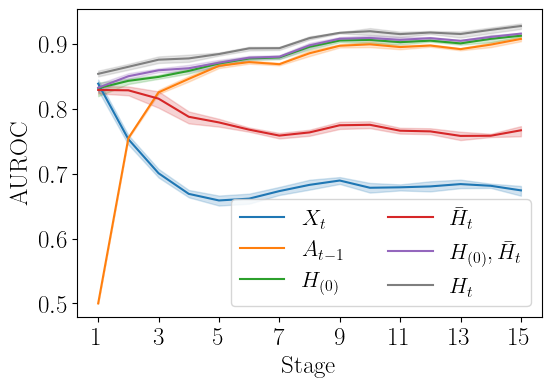

In [31]:
mask = (
    sepsis_time.Estimator.isin(['DT', 'PSN'])
    & ~sepsis_time.State.isin([r'$H_{(1)}, \bar{H}_t$', r'$H_{(2)}, \bar{H}_t$'])
    & sepsis_time.Reduction.isin(['sum', 'none'])
    & sepsis_time.Stage.le(15) 
    & sepsis_time.Metric.eq('auc_weighted')
)

fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams.update(RC_DEFAULT)

sns.lineplot(sepsis_time[mask], x='Stage', y='Score', hue='State', ax=ax, palette=COLOR_MAPPER)

ax.set_xticks(range(1, 16, 2))
ax.set_ylabel('AUROC')
sns.move_legend(ax, "lower right", bbox_to_anchor=(1, 0), ncol=2, title=None, frameon=True)

fig.savefig('sepsis_time.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

## RA analysis

In [32]:
ra_results = joblib.load('/mimer/NOBACKUP/groups/inpole/results/results_ra.pickle')

### OPE ratios

In [33]:
ra_ope = pd.DataFrame(ra_results['rho'][1:], columns=ra_results['rho'][0])
ra_ope.Estimator.replace(ESTIMATOR_MAPPER, inplace=True)

In [34]:
# Take the median of inverse probability products (IPPs).
ra_ope['mipp'] = ra_ope.Rho.apply(lambda rho: np.median(1 / np.array(rho)))

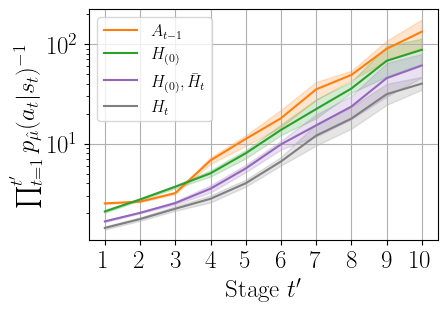

In [35]:
excluded_states = ['$X_t$', r'$\bar{H}_t$', r'$H_{(1)}, \bar{H}_t$', r'$H_{(2)}, \bar{H}_t$']

mask = (
    ra_ope.Estimator.isin(['LR', 'RNN'])
    & ~ra_ope.State.isin(excluded_states)
    & ra_ope.Reduction.isin(['max', 'none'])
    & ra_ope.Stage.ge(1)  # Ignore -1
    & ra_ope.Stage.le(10)
)

fig, ax = plt.subplots(figsize=(4.5, 3))
plt.rcParams.update(RC_SMALL)

sns.lineplot(
    data=ra_ope[mask], x='Stage', y='mipp', hue='State', 
    palette=COLOR_MAPPER, ax=ax, zorder=100,
)

ax.set_xticks(range(1, 11))
ax.set_xlabel('Stage $t^{\prime}$')
ax.set_ylabel('$\prod_{t=1}^{t^\prime}p_{\hat{\mu}}(a_t|s_t)^{-1}$')
ax.set_yscale('log')
ax.grid(zorder=-100)
sns.move_legend(ax, "upper left", ncol=1, title=None, frameon=True)

fig.savefig('ra_ope.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

### Simple vs. complex models

In [36]:
ra_probas = pd.DataFrame(ra_results['probas'][1:], columns=ra_results['probas'][0])
ra_probas.Estimator.replace(ESTIMATOR_MAPPER, inplace=True)

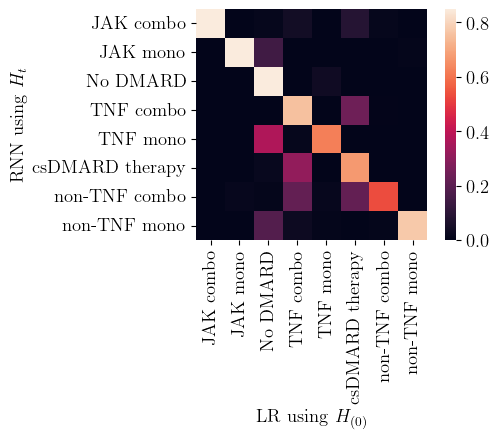

In [37]:
ra_data_path = '/mimer/NOBACKUP/groups/inpole/data/ra_Xgy_0819.pkl'

state_true = '$H_t$'
estimator_true = 'RNN'

state_pred = '$H_{(0)}$'
estimator_pred = 'LR'

y_true_all, y_pred_all, _X, _y = compare_ra_models(
    ra_probas,
    ra_data_path,
    state_true=state_true,
    estimator_true=estimator_true,
    state_pred=state_pred,
    estimator_pred=estimator_pred,
    switches_only=True,
)

C = confusion_matrix(y_true_all, y_pred_all, normalize='true')

fig, ax = plt.subplots(figsize=(4.5, 3))
plt.rcParams.update(RC_SMALL)

labels = RAData(path=ra_data_path).get_labels()
sns.heatmap(C, xticklabels=labels, yticklabels=labels, robust=True, square=True, ax=ax)

ax.set_xlabel(f"{estimator_pred} using {state_pred}")
ax.set_ylabel(f"{estimator_true} using {state_true}")

fig.savefig('ra_confusion.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

### Model complexity

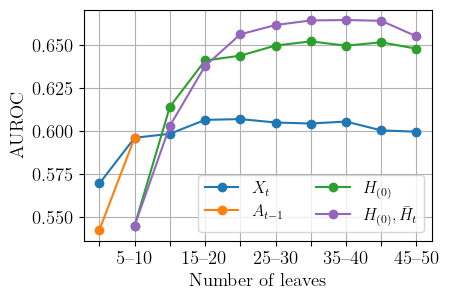

In [38]:
path = partial(join, '/mimer/NOBACKUP/groups/inpole/results/ra')
bins = range(0, 55, 5)

fig, ax = plt.subplots(figsize=(4.5, 3))
plt.rcParams.update(RC_SMALL)

estimators = [
    ('dt', path('20240903_2237_sweep/sweep/trial_01/'), bins, '$X_t$', COLOR_MAPPER['$X_t$'], ax),
    ('dt', path('20240903_2238_sweep/sweep/trial_01/'), bins, '$A_{t-1}$', COLOR_MAPPER['$A_{t-1}$'], ax),
    ('dt', path('20240903_2239_sweep/sweep/trial_01/'), bins, '$H_{(0)}$', COLOR_MAPPER['$H_{(0)}$'], ax),
    #('dt', path('20240903_2240_sweep/sweep/trial_01/'), bins, r'$\bar{H}_t$', COLOR_MAPPER[r'$\bar{H}_t$'], ax),
    ('dt', path('20240903_2241_sweep/sweep/trial_01/'), bins, r'$H_{(0)}, \bar{H}_t$', COLOR_MAPPER[r'$H_{(0)}, \bar{H}_t$'], ax),
    #('dt', path('20240903_2242_sweep/sweep/trial_01/'), bins, r'$H_{(1)}, \bar{H}_t$', COLOCOLOR_MAPPER[r'$H_{(1)}, \bar{H}_t$'], ax),
    #('dt', path('20240903_2243_sweep/sweep/trial_01/'), bins, r'$H_{(2)}, \bar{H}_t$', COLORCOLOR_MAPPER[r'$H_{(2)}, \bar{H}_t$'], ax),
]

plot_model_complexity(estimators, subset='test_s', metric='auc_macro')

ax.tick_params(axis='x', labelrotation=0)
ax.set_xticks(ax.get_xticks(), ['', '5--10', '', '15--20', '', '25--30', '', '35--40', '', '45--50'])
ax.set_xlabel('Number of leaves')
ax.set_ylabel('AUROC')
ax.grid('on')
ax.legend()
sns.move_legend(ax, 'lower right', ncol=2, title=None, frameon=True)

#fig.savefig('ra_complexity.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

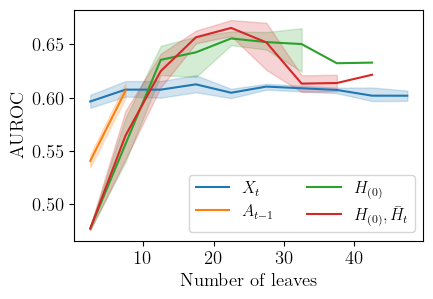

In [39]:
n_trials = 5
estimator = 'dt'
subset = 'test_s'
metric = 'auc_macro'

bins = range(0, 55, 5)

experiment_paths = [
    ('$X_t$', '/mimer/NOBACKUP/groups/inpole/results/ra/20240906_0704_sweep/sweep/'),
    ('$A_{t-1}$', '/mimer/NOBACKUP/groups/inpole/results/ra/20240906_0705_sweep/sweep/'),
    ('$H_{(0)}$', '/mimer/NOBACKUP/groups/inpole/results/ra/20240906_0706_sweep/sweep/'),
    (r'$H_{(0)}, \bar{H}_t$', '/mimer/NOBACKUP/groups/inpole/results/ra/20240906_0707_sweep/sweep/' ),
]

D = {'state': [], 'trial': [], 'x': [], 'y': []}

for state, experiment_path in experiment_paths:
    for trial in range(1, n_trials + 1):
        trial_path = join(experiment_path, f'trial_{trial:02d}')
        complexities, scores = get_model_complexities_and_scores(trial_path, estimator, subset, metric)

        indices = np.digitize(complexities, bins)
        
        x, y = [], []
        for i in range(1, len(bins)):
            if i in indices:
                le, re = bins[i-1], bins[i]
                x.append(le + (re - le) / 2)
                y.append(max(scores[indices==i]))

        D['state'].append(state)
        D['trial'].append(trial)
        D['x'].append(x)
        D['y'].append(y)

D = pd.DataFrame(D).explode(column=['x', 'y'])

fig, ax = plt.subplots(figsize=(4.5, 3))
plt.rcParams.update(RC_SMALL)

sns.lineplot(D, x='x', y='y', hue='state', ax=ax)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.set_xlabel('Number of leaves')
ax.set_ylabel('AUROC')
sns.move_legend(ax, 'lower right', ncol=2, title=None, frameon=True)

## Datasets

### ADNI

In [40]:
adni = pd.read_pickle('/mimer/NOBACKUP/groups/inpole/data/adni_Xgy.pkl')

In [43]:
describe_dataset(adni, 'RID', 'AGE', 'PTGENDER', i_female=None, v_female='Female')

Patients, n: 1605
Age in years, median (IQR): 73.9 (69.3, 78.8)
Female, n (%): 715 (44.5)
Stages, median IQR): 3.0 (3.0, 3.0)


In [ ]:
#adni_categorical = adni.groupby('RID').first().select_dtypes(include=['category', 'bool'])
#adni_categorical = describe_categorical(adni_categorical)
#display_dataframe(adni_categorical)

In [ ]:
#adni_numerical = adni.groupby('RID').first().select_dtypes(include=['number'])
#adni_numerical = describe_numerical(adni_numerical)
#display_dataframe(adni_numerical, precision=1)

### RA

In [44]:
ra = pd.read_pickle('/mimer/NOBACKUP/groups/inpole/data/ra_Xgy_0901.pkl')

In [45]:
describe_dataset(ra[ra.stage.ge(1)], 'id', 'age', 'gender', i_female=None, v_female='female')

Patients, n: 4391
Age in years, median (IQR): 59.0 (50.0, 67.0)
Female, n (%): 3355 (76.5)
Stages, median IQR): 5.0 (3.0, 8.0)


In [46]:
#ra_categorical = ra[ra.stage.eq(1)].select_dtypes(include=['category', 'bool'])
#ra_categorical = describe_categorical(ra_categorical)
#ra_categorical = ra_categorical[ra_categorical.index.get_level_values('Variable') != 'taes']
#display_dataframe(ra_categorical)

In [47]:
#ra_numerical = ra[ra.stage.eq(1)].select_dtypes(include=['number'])
#ra_numerical = describe_numerical(ra_numerical)
#display_dataframe(ra_numerical)

### Sepsis

In [48]:
sepsis = pd.read_csv('/mimer/NOBACKUP/groups/inpole/data/sepsis_data.csv')

In [49]:
sepsis['age_y'] = sepsis.age / 365.25
describe_dataset(sepsis, 'icustayid', 'age_y', 'gender', i_female=1)

Patients, n: 20932
Age in years, median (IQR): 66.1 (53.7, 77.9)
Female, n (%): 9250 (44.2)
Stages, median IQR): 13.0 (10.0, 17.0)


### COPD

In [50]:
copd = pd.read_csv('/mimer/NOBACKUP/groups/oovgen/inpole/data/copd/COPD_2003.csv')

In [51]:
copd.gender = copd.gender.astype('category')
describe_dataset(copd, 'PatientID', 'Age', 'gender', i_female=None, v_female='F')

Patients, n: 7977
Age in years, median (IQR): 67.0 (56.0, 77.0)
Female, n (%): 3472 (43.5)
Stages, median IQR): 18.0 (18.0, 18.0)


### Prepare data for CPR

In [52]:
def _format_cpr_data(preprocessor, X, y):
    Xt = preprocessor.transform(X)
    columns = get_feature_names(preprocessor).tolist() + ['id']
    D = pd.DataFrame(Xt, columns=columns)
    D['time'] = D.groupby('id').cumcount() + 1 
    D['target'] = y
    return D

experiment = 'adni'
experiment_path = '/mimer/NOBACKUP/groups/inpole/results/adni/20240904_1407_sweep'  # S_t = H_t

save_to = '/mimer/NOBACKUP/groups/inpole/data/cpr/'

for trial in [1, 2, 3, 4, 5]:
    pipeline, results_path = load_best_pipeline(experiment_path, trial, 'rnn', return_results_path=True)
    preprocessor = pipeline.named_steps['preprocessor']
    
    config_path = join(results_path, 'config.yaml')
    config = load_config(config_path)    
    data_handler = get_data_handler_from_config(config)

    splits =  data_handler.get_splits()
    
    for i, subset in enumerate(['train', 'valid', 'test']):
        D = _format_cpr_data(preprocessor, *splits[i])
        file_name = f'{experiment}_{trial}_{subset}.pkl'
        #D.to_pickle(join(save_to, file_name))